<a href="https://colab.research.google.com/github/MohmedAAK/-Advanced-computer-vision-v1/blob/main/Advanced%20computer%20vision/team4/challenges/dog_or_cat_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# P

In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

 95% 257M/271M [00:05<00:00, 44.5MB/s]
100% 271M/271M [00:05<00:00, 52.3MB/s]
 99% 537M/543M [00:05<00:00, 109MB/s]
100% 543M/543M [00:05<00:00, 96.4MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 45.8MB/s]


In [ ]:
!unzip /content/train.zip

In [ ]:
!unzip /content/test1.zip

In [5]:
filenames=os.listdir("/content/train")

categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

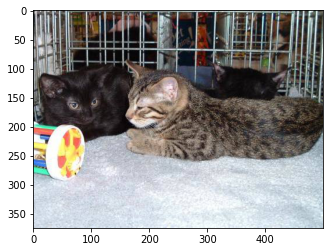

In [7]:
sample = random.choice(filenames)
image = load_img("/content/train/"+sample)
plt.imshow(image)

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH,IMAGE_HEIGHT)
IMAGE_CHANNELS=3

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [7]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]


# Prepare data

In [8]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [9]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

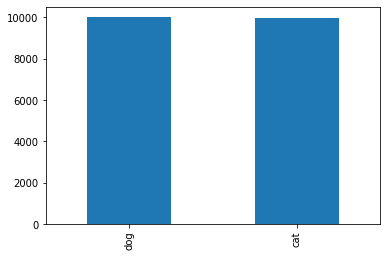

In [10]:
train_df['category'].value_counts().plot.bar()

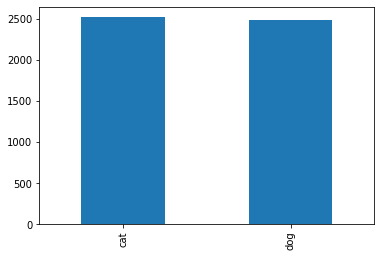

In [11]:
validate_df['category'].value_counts().plot.bar()

In [12]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [14]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# See how our generator work

In [15]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


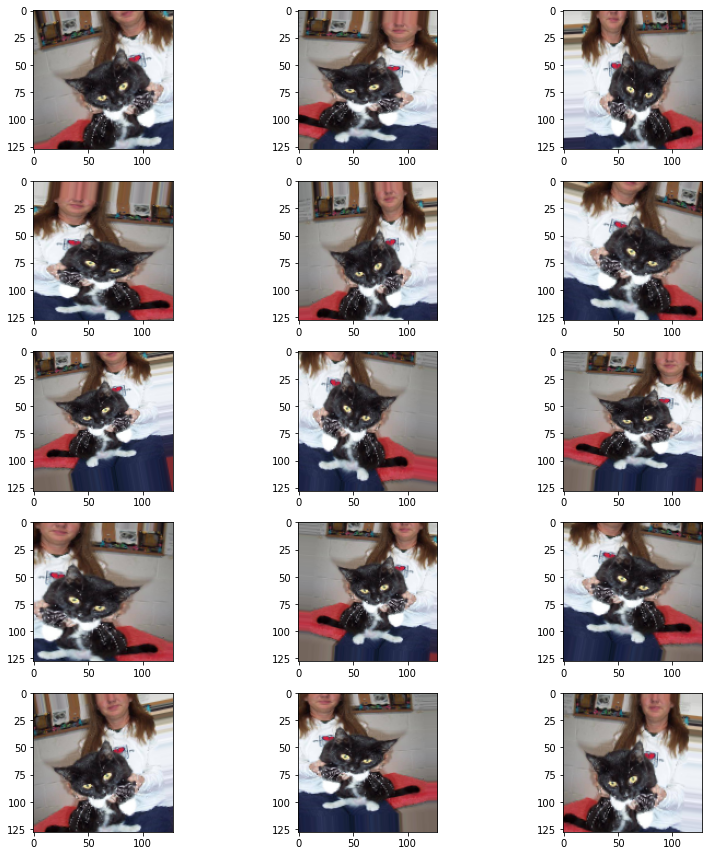

In [16]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

# Fit Model

In [17]:
FAST_RUN=0
epochs=3 if FAST_RUN else 30
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
1333/1333 [==============================] - 193s 137ms/step - loss: 0.7320 - accuracy: 0.6409 - val_loss: 0.5294 - val_accuracy: 0.7375 - lr: 0.0010
Epoch 2/30
1333/1333 [==============================] - 177s 132ms/step - loss: 0.5468 - accuracy: 0.7246 - val_loss: 0.6067 - val_accuracy: 0.7245 - lr: 0.0010
Epoch 3/30
1333/1333 [==============================] - 182s 137ms/step - loss: 0.5038 - accuracy: 0.7609 - val_loss: 0.5818 - val_accuracy: 0.7766 - lr: 0.0010
Epoch 4/30
1333/1333 [==============================] - 177s 133ms/step - loss: 0.4599 - accuracy: 0.7871 - val_loss: 0.4826 - val_accuracy: 0.7910 - lr: 0.0010
Epoch 5/30
1333/1333 [==============================] - 177s 133ms/step - loss: 0.4347 - accuracy: 0.8003 - val_loss: 0.3532 - val_accuracy: 0.8549 - lr: 0.0010
Epoch 6/30
1333/1333 [==============================] - 177s 133ms/step - loss: 0.4146 - accuracy: 0.8167 - val_loss: 0.8084 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 7/30
1333/1333 [============

# Save Model

In [19]:
model.save_weights("model.h5")

# Virtualize Training

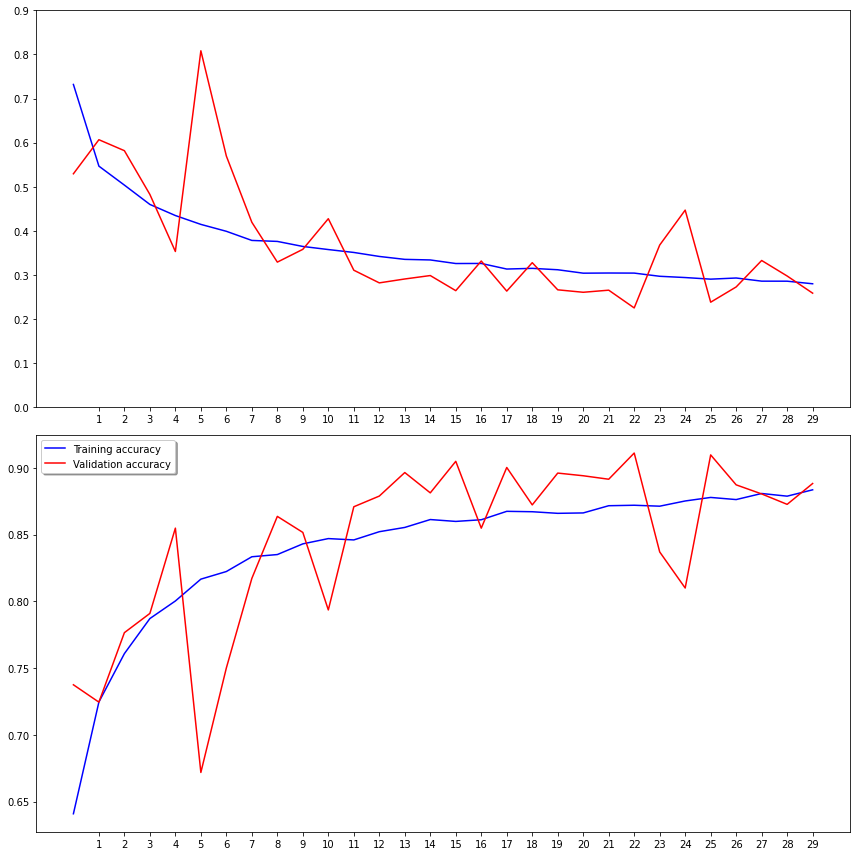

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [ ]:
test_filenames = os.listdir("/content/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 images.


# Predict

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to dog is 1 and cat is 0

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

### Virtaulize Result

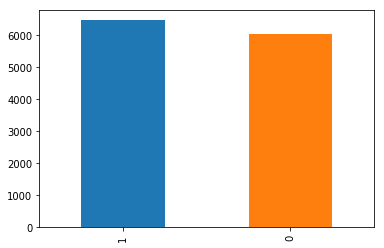

In [ ]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

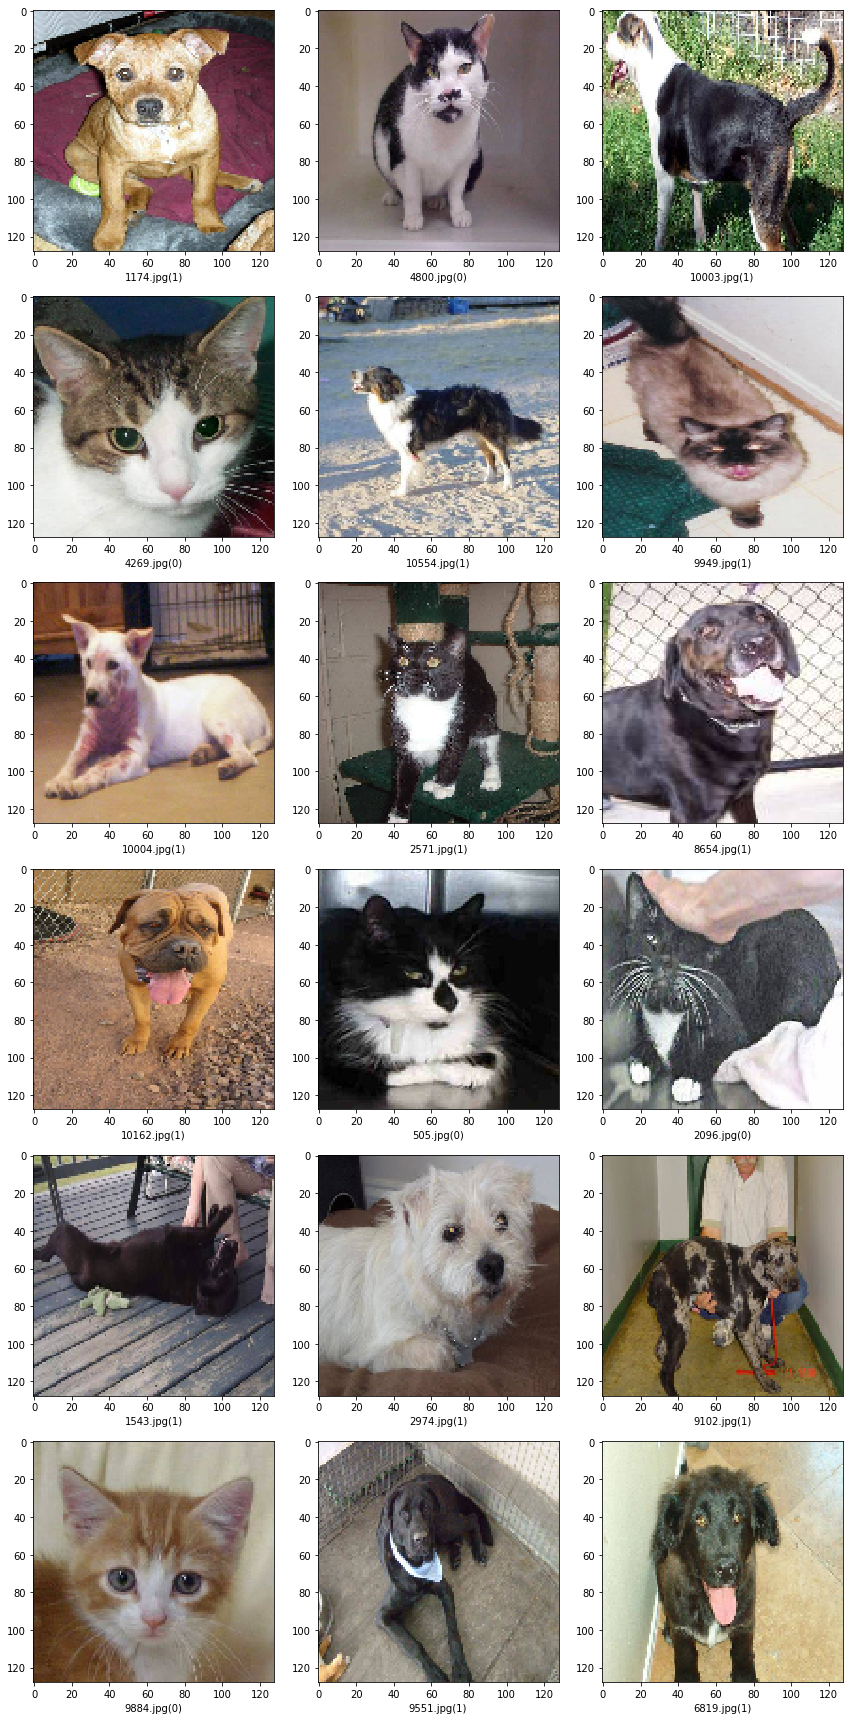

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../input/test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

# Submission

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)